In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Feed Forward Networks

## The Network

We start with a FFNN with one input node $x$, one hidden layer $AF1$ with two nodes and one output node $y$ with linear layer:

###### Hide

In [2]:
G=nx.Graph()
G.add_nodes_from(np.arange(1,7))
G.add_edges_from([
    (1,2),(1,3), #inputnodes
    (2,4),(3,5), #sum to first HL
    (4,6),(5,6), #first HL to sum
    (6,7) #sum to outputnodes
])

In [3]:
el={
    (1,2):'w0_0,0',(1,3):'w0_0,1',
    (2,4):'b0_0',(3,5):'b0_1',
    (4,6):'w1_0,0',(5,6):'w1_1,0',
    (6,7):'b1_0'
}

In [4]:
labels = {
    1:r"$x$",
    2:r"$+$",
    3:r"$+$",
    4:r"$AF1_0$",
    5:r"$AF1_1$",
    6:r"$+$",
    7:r"$y$"
}

In [5]:
pos = {
    1:np.array([-2,2]), #Input Node
    2:np.array([3,4]), #Sum
    3:np.array([3,0]),
    4:np.array([6,4]), #First HL
    5:np.array([6,0]),
    6:np.array([10,2]), #Sum
    7:np.array([12,2]) #Output Nodes
}

In [6]:
color_map2 = []
for node in G:
    if node==1:
        color_map2.append('cornflowerblue')
    elif 1<node<4 or node==6:
        color_map2.append('black')
    elif 3<node<6:
        color_map2.append('red')
    else: 
        color_map2.append('green')

###### Plot

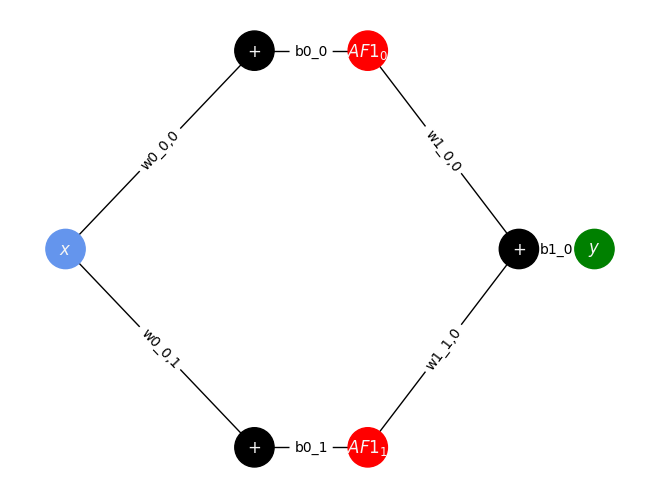

In [7]:
nx.draw(G, pos, node_color=color_map2,node_size=800)#, with_labels=True)
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color="whitesmoke")
nx.draw_networkx_edge_labels(G, pos, edge_labels = el)
plt.show()

Now, we can go directly through the network, for example:
$$tmp=w0_{0,0}*x+b0_0$$
and then we get
$$AF1_0=AF1(tmp)$$
where $AF1$ is an activation function. We have several [options](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for the activation function, for example
- Relu: $AF1(x)=max(0,x)$
- Softplus: $AF1(x)=log(e^{x}+1)$
- ...
If we do this for the entire network, we get for the output node $y$:
$$y=w1*AF1+b1=w1*AF1(w0*x+b0)$$
where the activation function $AF1$ is applied component wise.

## Network in torch

The translation of our network in a torch model is quite simple. Torch just needs to know the architecture and then perfoms the same calculation as we did manually:

In [8]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) #Input layer (blue)
        self.sp1 = nn.Softplus() #Hidden layer (red)
        self.fc2 = nn.Linear(hidden_size1, output_size) #Output layer (green)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sp1(x)
        x = self.fc2(x)
        return x

input_size, hidden_size1, output_size = 1, 2, 1
model = FeedForwardNN(input_size, hidden_size1, output_size)
print(model)

FeedForwardNN(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (sp1): Softplus(beta=1.0, threshold=20.0)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)


## Training

We now know how the forward pass of a FNN works, but we still need the weights and bias $w$ and $b$ in order to calculate an output $y$ from an input $x$. This is where _training_ comes into play. We start with some inital weights and biases and then try to optimize $w$ and $b$ so that for some testdata $x_{test}$ the output $y$ of FNN best matches the output testdata $y_{test}$. This process is done by _backpropagation_, which is based on _gradient descent_.

## Training in torch

Torch does this backpropagation internally. Torch therefore only needs the test data $x_{test}$ and $y_{test}$ and our previously defined model. In addition, we have to choose our loss function, the optimizer with learning rate and the number of epochs.

Epoch [100/500], Loss: 0.1984
Epoch [200/500], Loss: 0.1527
Epoch [300/500], Loss: 0.0117
Epoch [400/500], Loss: 0.0064
Epoch [500/500], Loss: 0.0142


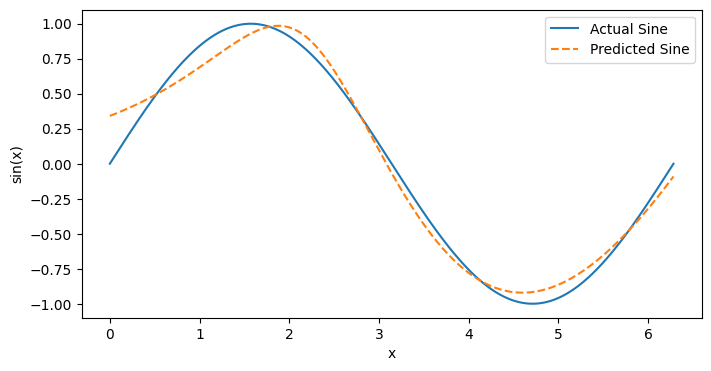

In [9]:
# Generate dataset for sine curve approximation
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Convert numpy arrays to torch tensors and add a feature dimension
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create a TensorDataset and DataLoader for batch processing
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Set up the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate predictions after training
with torch.no_grad():
    predicted = model(x_tensor).detach().numpy()

# Plot the actual sine curve and the network's predictions
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Actual Sine')
plt.plot(x, predicted, label='Predicted Sine', linestyle='--')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()


We see, that the predicted model does not fit perfectly our "true" model. Reasons for this can be:
- too simple architecture -> more hidden layer, other activation functions,...
- more epochs required
- more trainings data required
- ...
this is the so-called _hyperparameter tuning_!

Remark: For complex networks with e.g. two input nodes, another problems can be the size of the inputs (e.g. one input is temperature and one is a cloud variable). In this case, you must first normalize your inputs before training your model.


# More examples

In [10]:
import torch
import torch.nn as nn

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size, hidden_size1, hidden_size2, output_size = 1, 8, 6, 1
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)
print(model)

FeedForwardNN(
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=8, out_features=6, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=6, out_features=1, bias=True)
)


## Function Approximation using FFNN

Epoch 500, Loss: 0.000031
Epoch 1000, Loss: 0.000015
Epoch 1500, Loss: 0.000013
Epoch 2000, Loss: 0.000013


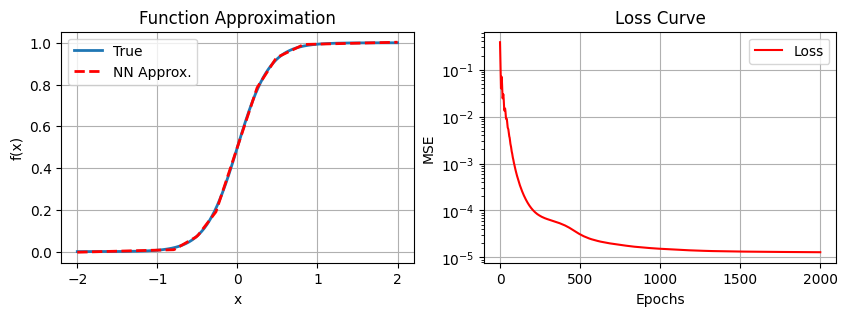

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42); np.random.seed(42)
x = np.linspace(-2, 2, 500)
y = 1 / (1 + np.exp(-5 * x))
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class DeepFFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1, self.fc2, self.fc3 = nn.Linear(1, 8), nn.Linear(8, 6), nn.Linear(6, 1)
    def forward(self, x): return self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(x)))))

model = DeepFFNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = []
for epoch in range(2000):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 500 == 0: print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

with torch.no_grad(): y_pred_np = model(x_tensor).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(x, y, label="True", linewidth=2)
axes[0].plot(x, y_pred_np, "r--", label="NN Approx.", linewidth=2)
axes[0].set(title="Function Approximation", xlabel="x", ylabel="f(x)"); axes[0].legend(); axes[0].grid()
axes[1].semilogy(loss_history, "r", label="Loss")
axes[1].set(title="Loss Curve", xlabel="Epochs", ylabel="MSE"); axes[1].legend(); axes[1].grid()
plt.savefig("deep_nn_results.png")
plt.show()